# scikit-learnのトレーニング♨

## 単回帰、重回帰分析 編

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
  - [インポート](#インポート)
  - [プロキシ設定](#プロキシ設定)
  - [共通関数定義](#共通関数定義)
- [モデル・アルゴリズム](#モデル・アルゴリズム)
  - [単回帰分析](#単回帰分析)
  - [重回帰分析](#重回帰分析)

## 参考
開発基盤部会 Wiki
- データマイニング（DM）- Python  
https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20Python#y4054d35

## [環境準備](ScikitLearnTraining0.ipynb)

### インポート

In [1]:
import io
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets                                 # サンプル・データセット
from sklearn.datasets import make_regression                 # 回帰データセット作成
from sklearn.datasets import make_blobs                      # 分類データセット作成
from sklearn.preprocessing import StandardScaler             # 標準化
from sklearn.model_selection import train_test_split         # データ分割

from sklearn.linear_model import LinearRegression            # 線形回帰
from sklearn.preprocessing import PolynomialFeatures         # 多項式回帰の変数変換
from sklearn.linear_model import Ridge                       # 多項式回帰のRidge回帰
from sklearn.linear_model import Lasso                       # 多項式回帰のLASSO回帰
from sklearn.linear_model import ElasticNet                  # 多項式回帰のLASSO回帰
from sklearn.linear_model import Perceptron                  # 単純パーセプトロン線形分類器
from sklearn.linear_model import LogisticRegression          # ロジスティク回帰
from sklearn.svm import SVC                                  # サポートベクターマシン（SVM）分類器
from sklearn.tree import DecisionTreeClassifier              # 決定木（分類木）
from sklearn.ensemble import RandomForestClassifier          # ランダムフォレスト（分類木）
from sklearn.ensemble import GradientBoostingClassifier      # 勾配ブースティング木（分類木）
from sklearn.decomposition import PCA                        # 主成分分析
from sklearn.cluster import KMeans                           # k-means法 クラスタ分析
from sklearn.feature_extraction.text import CountVectorizer  # 自然言語処理ベクトル化
from sklearn.feature_extraction.text import TfidfTransformer # 自然言語ベクトルのTF-IDF計算
from sklearn.decomposition import LatentDirichletAllocation  # 自然言語ベクトルからLDAトピック抽出

from sklearn import metrics                                  # モデル評価
from sklearn.metrics import mean_squared_error as mse        # 精度評価（mse）
from sklearn.metrics import confusion_matrix                 # 混同行列
from sklearn.metrics import silhouette_samples               # シルエット係数
from sklearn.model_selection import cross_val_score          # 交差検証法
from sklearn.model_selection import KFold                    # k分割交差検証法
from sklearn.model_selection import StratifiedKFold          # 層化交差検証法
from sklearn.model_selection import GridSearchCV             # グリッドサーチ

import seaborn as sns                                        # matplotlibラッパ
from mlxtend.plotting import plot_decision_regions           # 決定領域表示関数
from matplotlib import cm                                    # カラーマップ処理

from numpy import linalg as LA                               # 線形代数ライブラリ

In [2]:
import warnings
warnings.filterwarnings('ignore')

### プロキシ設定

In [3]:
import os
proxies = {
    "http": os.getenv("HTTP_PROXY"),
    "https": os.getenv("HTTPS_PROXY")
}

### 共通関数定義

#### 残差プロットを行う関数

In [4]:
def res_plot(y_train, y_train_pred, y_test, y_test_pred):
    # train, testごとに残差を算出
    res_train = y_train_pred - y_train
    res_test  = y_test_pred - y_test
    
    # train, testごとに(予測値, 残差)をプロット
    plt.figure(figsize=(8, 8))
    plt.scatter(y_train_pred, res_train, color='blue', marker='o', label='train', alpha=0.5)
    plt.scatter(y_test_pred, res_test, color='green', marker='s', label='test', alpha=0.5)
    
    plt.xlabel('Predicted Values')                  # x軸のラベルを表示
    plt.ylabel('Residuals')                         # y軸のラベルを表示
    plt.legend(loc='upper left')                    # 凡例を左上に表示
    plt.hlines(y=0, xmin=-10, xmax=50, color='red') # 残差0の線を表示
    plt.xlim([-10, 50])                             # 表示する横軸の範囲を指定
    plt.show()

## モデル・アルゴリズム

### 単回帰分析
- 線形単回帰分析（分布を直線の１次関数で近似
- 最小二乗法で直線の１次関数を求める。

※ [イメージ](https://www.google.com/search?q=単回帰分析&tbm=isch)、[説明](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E7%B5%B1%E8%A8%88%E8%A7%A3%E6%9E%90#a421ea17)

#### データ

##### 生成
- その日の最高気温と売れたアイスの個数のデータを利用。
- 必要に応じて[環境変数にプロキシ設定](#プロキシ設定)をしておくと良い。

In [5]:
url = 'https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?plugin=attach&pcmd=open&file=n_ice%2Bvs%2Btemp.xlsx&refer=FrontPage'
res = requests.get(url) # , verify=False, proxies=proxies) # プロキシ
df = pd.read_excel(io.BytesIO(res.content), engine='openpyxl')
df

,Unnamed: 0,MAX_TEMP,N_ICE
0,0,27,167
1,1,17,80
2,2,21,98
3,3,30,167
4,4,28,124
...,...,...,...
95,95,19,107
96,96,15,101
97,97,27,152
98,98,15,126


##### 加工

In [6]:
df=df.drop('Unnamed: 0',axis=1)
df

,MAX_TEMP,N_ICE
0,27,167
1,17,80
2,21,98
3,30,167
4,28,124
...,...,...
95,19,107
96,15,101
97,27,152
98,15,126


##### 理解

In [7]:
# 基本統計量
df.describe()

,MAX_TEMP,N_ICE
count,100.000000,100.00000
mean,14.930000,92.44000
std,7.061426,33.88761
min,-2.000000,13.00000
25%,10.000000,72.25000
50%,15.000000,91.50000
75%,20.000000,118.25000
max,30.000000,167.00000


In [8]:
# 相関係数（相関行列）
df.corr()

,MAX_TEMP,N_ICE
MAX_TEMP,1.000000,0.889654
N_ICE,0.889654,1.000000


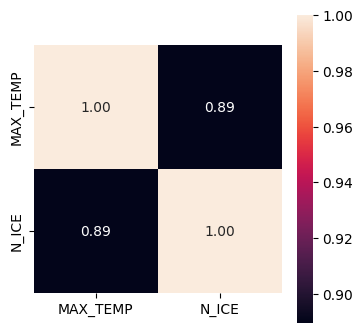

In [9]:
# ヒートマップに表示
plt.figure(figsize=(4, 4))
sns.heatmap(df.corr(), annot=True, square=True, fmt='.2f')
plt.show()

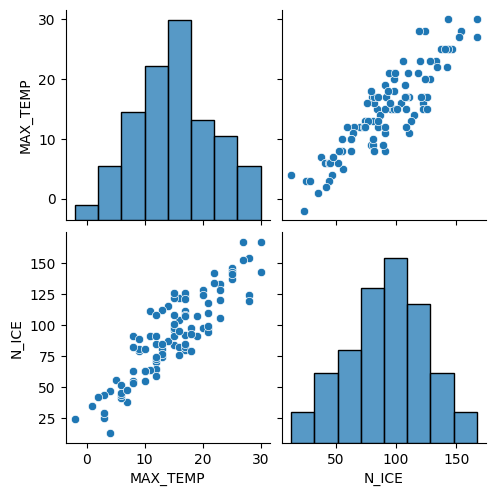

In [10]:
# 散布図行列を表示
sns.pairplot(df)
plt.show()

##### 準備

In [11]:
# 説明変数・目的変数の選択・分割
x = np.array(df.loc[:, ['MAX_TEMP']])
y = np.array(df.loc[:, ['N_ICE']])
# データをスライシングして確認。
print(x[:5])
print(y[:5])

[[27]
 [17]
 [21]
 [30]
 [28]]
[[167]
 [ 80]
 [ 98]
 [167]
 [124]]


In [12]:
# 学習・テストデータの分割（ホールド・アウト法
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

#### モデリング

##### 学習
※ fitは多変量に対応しているので二次元配列であること。

In [13]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

lr = LinearRegression()
lr.fit(x, y)

##### 推論
※ predictは多変量に対応しているので二次元配列であること。

In [14]:
index=6
new_val = np.array([x_test[index]])
pred_val = lr.predict(new_val)
ratio_val = y_test[index] / pred_val[0]
print('answer = ', y_test[index])
print('pred = ', pred_val[0])
print('ratio : %.2f' % ratio_val)

answer =  [146]
pred =  [136.64322872]
ratio : 1.07


#### 評価

##### 回帰直線
y = lr.coef_[0] * x + lr.intercept_

In [15]:
print('coefficient = ', lr.coef_[0]) # 係数
print('intercept = ', lr.intercept_) # 切片

coefficient =  [4.31834154]
intercept =  [28.68469012]


##### 決定係数（R2乗値）
絶対的な基準でないが0.5以上であれば適合度が高い

In [16]:
print('R^2')
print('train: %.3f' % lr.score(x_train, y_train))
print('test : %.3f' % lr.score(x_test, y_test))

R^2
train: 0.773
test : 0.833


##### 散布図に回帰直線を追加

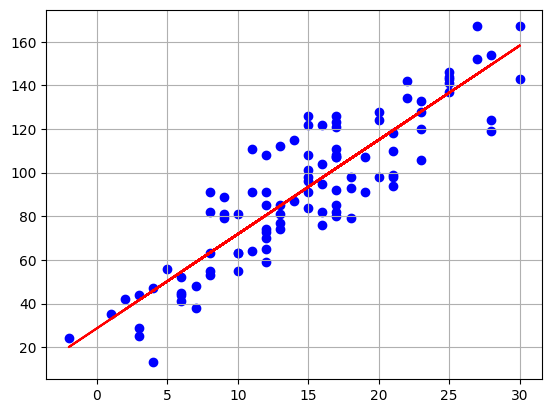

In [17]:
plt.scatter(x, y, color = 'blue')
plt.plot(x, lr.predict(x), color = 'red')
plt.grid()
plt.show()

### 重回帰分析
- 線形重回帰分析（分布を（超）平面などの１次関数で近似
- ３変数以上の最小二乗法は勾配降下法で解く

※ [イメージ](https://www.google.com/search?q=重回帰分析&tbm=isch)、[説明](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E7%B5%B1%E8%A8%88%E8%A7%A3%E6%9E%90#na76c5ec)

#### データ

##### 生成

###### ダウンロードしてDFに読込
必要に応じて[環境変数にプロキシ設定](#プロキシ設定)をしておくと良い。

In [18]:
# Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.
'''
## bostonデータを格納したクラス
from sklearn.datasets import load_boston
## インスタンスを生成
boston = load_boston()
## データの詳細を出力
print(boston.DESCR)
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df
'''

'\n## bostonデータを格納したクラス\nfrom sklearn.datasets import load_boston\n## インスタンスを生成\nboston = load_boston()\n## データの詳細を出力\nprint(boston.DESCR)\ndf = pd.DataFrame(boston.data, columns=boston.feature_names)\ndf\n'

In [19]:
url = 'https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?plugin=attach&pcmd=open&file=Boston.csv&refer=FrontPage'
res = requests.get(url) # , verify=False, proxies=proxies) # プロキシ
df = pd.read_csv(io.BytesIO(res.content), encoding='utf-8', sep=",")
df

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,502,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,503,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,504,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,505,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


###### [説明を参照](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20DataSet#j8cfe8df)

In [20]:
df.columns

Index(['Unnamed: 0', 'crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis',
       'rad', 'tax', 'ptratio', 'black', 'lstat', 'medv'],
      dtype='object')

##### 加工

In [21]:
df=df.drop('Unnamed: 0',axis=1)
df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [22]:
# 特徴量の数が多いので､locメソッドで一部の特徴量のみを選択
df = df.loc[:, ['lstat', 'indus', 'dis', 'rm', 'medv']]

##### 理解

In [23]:
# 基本統計量
df.describe()

,lstat,indus,dis,rm,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000
mean,12.653063,11.136779,3.795043,6.284634,22.532806
std,7.141062,6.860353,2.105710,0.702617,9.197104
min,1.730000,0.460000,1.129600,3.561000,5.000000
25%,6.950000,5.190000,2.100175,5.885500,17.025000
50%,11.360000,9.690000,3.207450,6.208500,21.200000
75%,16.955000,18.100000,5.188425,6.623500,25.000000
max,37.970000,27.740000,12.126500,8.780000,50.000000


In [24]:
# 相関係数（相関行列）
df.corr()

,lstat,indus,dis,rm,medv
lstat,1.000000,0.603800,-0.496996,-0.613808,-0.737663
indus,0.603800,1.000000,-0.708027,-0.391676,-0.483725
dis,-0.496996,-0.708027,1.000000,0.205246,0.249929
rm,-0.613808,-0.391676,0.205246,1.000000,0.695360
medv,-0.737663,-0.483725,0.249929,0.695360,1.000000


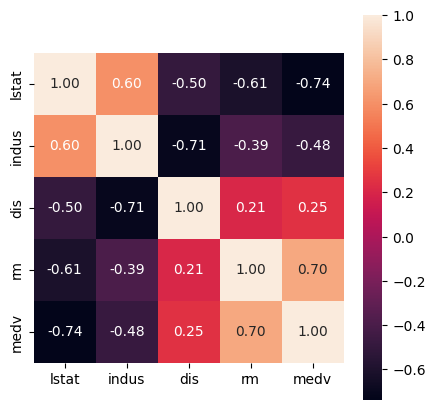

In [25]:
# ヒートマップに表示
plt.figure(figsize=(5, 5))
sns.heatmap(df.corr(), annot=True, square=True, fmt='.2f')
plt.show()

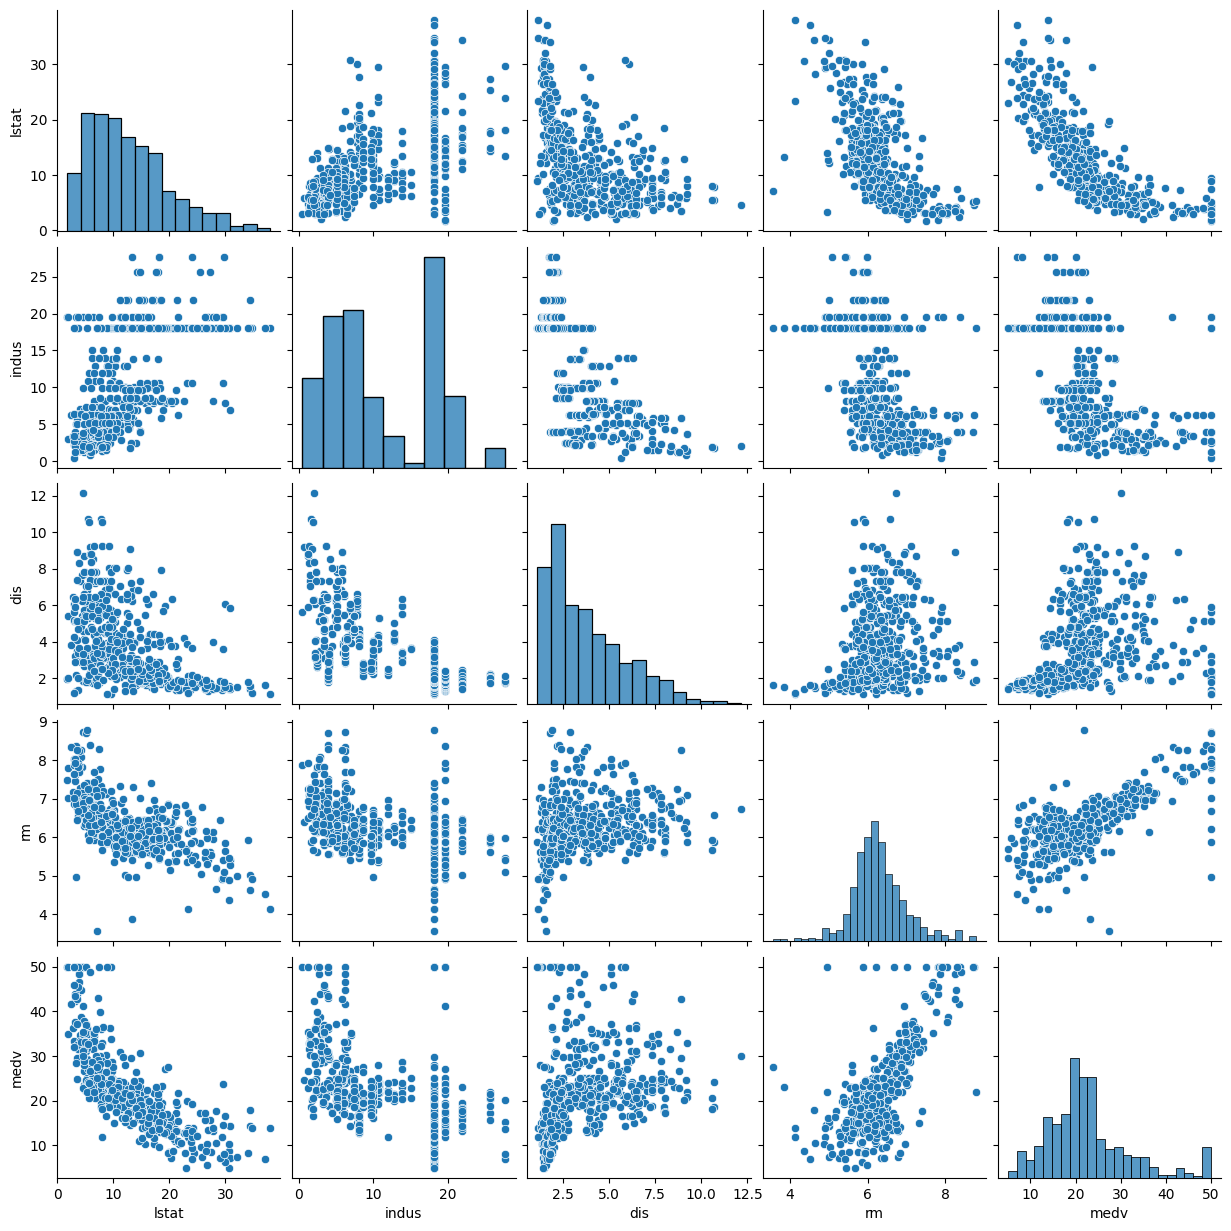

In [26]:
# 散布図行列を表示
sns.pairplot(df)
plt.show()

##### 準備

In [27]:
# 説明変数・目的変数の選択・分割
# x = np.array(df.drop(['medv'], axis=1))
x = np.array(df.drop(['indus', 'dis', 'medv'], axis=1))
y = np.array(df.loc[:, ['medv']])
# データをスライシングして確認。
print(x[:5])
print(y[:5])

[[4.98  6.575]
 [9.14  6.421]
 [4.03  7.185]
 [2.94  6.998]
 [5.33  7.147]]
[[24. ]
 [21.6]
 [34.7]
 [33.4]
 [36.2]]


In [28]:
# 偏回帰係数を見て、追加の特徴量エンジニアリングを行う場合
# 説明変数に標準化を施す必要がある。
'''
ss = StandardScaler()

# 引数は numpy.ndarray
x = ss.fit_transform(x)

# 確認
## 平均が ≒ 0
print("x.mean(): ", x.mean())
## 標準偏差が ≒ 1
print("x.std(): ", x.std())
'''

'\nss = StandardScaler()\n\n# 引数は numpy.ndarray\nx = ss.fit_transform(x)\n\n# 確認\n## 平均が ≒ 0\nprint("x.mean(): ", x.mean())\n## 標準偏差が ≒ 1\nprint("x.std(): ", x.std())\n'

In [29]:
# 学習・テストデータの分割（ホールド・アウト法
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

#### モデリング

##### 学習

In [30]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

##### 推論
※ predictは多変量に対応しているので二次元配列であること。

In [31]:
index=6
new_val = np.array([x_test[index]])
pred_val = lr.predict(new_val)
ratio_val = y_test[index] / pred_val[0]
print('answer = ', y_test[index])
print('pred = ', pred_val[0])
print('ratio : %.2f' % ratio_val)

answer =  [20.6]
pred =  [21.25383779]
ratio : 0.97


#### 評価

##### 重回帰超平面
- y = lr.coef_[0] * x1 + lr.coef_[1] * x2 * ... + lr.intercept_
- 偏回帰係数は、
  - データの標準化を施してあれば、追加の特徴量エンジニアリングで参考にできる。
  - ただし、抑制変数があるので、最終的には[R2乗値](#自由度調整済み決定係数（R2乗値）)を参考にする。

In [32]:
print('coefficient = ', lr.coef_) # 偏回帰係数
print('intercept = ', lr.intercept_) # 定数項

coefficient =  [[-0.6418309   5.27350522]]
intercept =  [-2.53724672]


##### 決定係数（R2乗値）
絶対的な基準でないが0.5以上であれば適合度が高い

In [33]:
print('R^2')
print('train: %.3f' % lr.score(x_train, y_train))
print('test : %.3f' % lr.score(x_test, y_test))

R^2
train: 0.651
test : 0.607


##### 自由度調整済み決定係数（R2乗値）

In [34]:
def adjusted(score, n_sample, n_explanatory_variables):
    adjusted_score = 1 - (1 - score) * ((n_sample - 1) / (n_sample - n_explanatory_variables - 1))
    return adjusted_score

print('train: %.3f' % adjusted(lr.score(x_train, y_train), len(y_train), x_train.shape[1]))
print('test : %.3f' % adjusted(lr.score(x_test, y_test), len(y_test), x_test.shape[1]))

train: 0.649
test : 0.602


##### [スコアを表示](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20CRISP-DM#uf759972)
- 平均二乗誤差（MSE：Mean Squared Error）
- 誤差の標準偏差（RMSE : Root Mean Squared Error）

In [35]:
train_mse = mse(y_train, lr.predict(x_train))
test_mse = mse(y_test, lr.predict(x_test))

print('train_mse: %.3f' % train_mse)
print('test_mse: %.3f' % test_mse)
print('train_rmse: %.3f' % (train_mse ** (1/2)))
print('test_rmse : %.3f' % (test_mse ** (1/2)))

train_mse: 29.588
test_mse: 32.725
train_rmse: 5.439
test_rmse : 5.721


##### 重回帰超平面の可視化
ただし、説明変数が２変数まで。

Text(0.5, 0, 'medv')

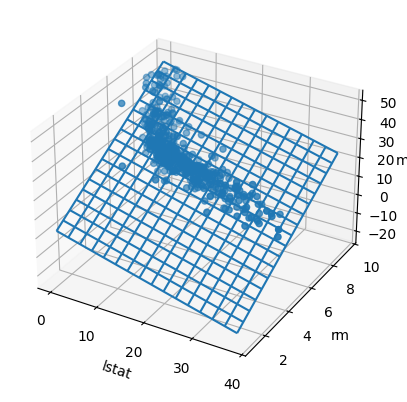

In [36]:
# 可視化

# import
from mpl_toolkits.mplot3d import Axes3D

# 平面のグリッド座標
w0 = lr.intercept_
w1 = lr.coef_[0, 0]
w2 = lr.coef_[0, 1]
x, y = np.meshgrid(np.arange(0, 40, 2.5), np.arange(1, 10, 0.5))
z = w1*x + w2*y + w0 

# 図表の定義
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# 3Dで Scat & plot
ax.scatter3D(df['lstat'], df['rm'], df['medv'])
ax.plot_wireframe(x, y, z)

# ラベル
ax.set_xlabel('lstat')
ax.set_ylabel('rm')
ax.set_zlabel('medv')

##### 残差プロットを行う。
- 説明変数が３変数以上でも適用できる。
- 参考：https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20CRISP-DM#i3d85f2b

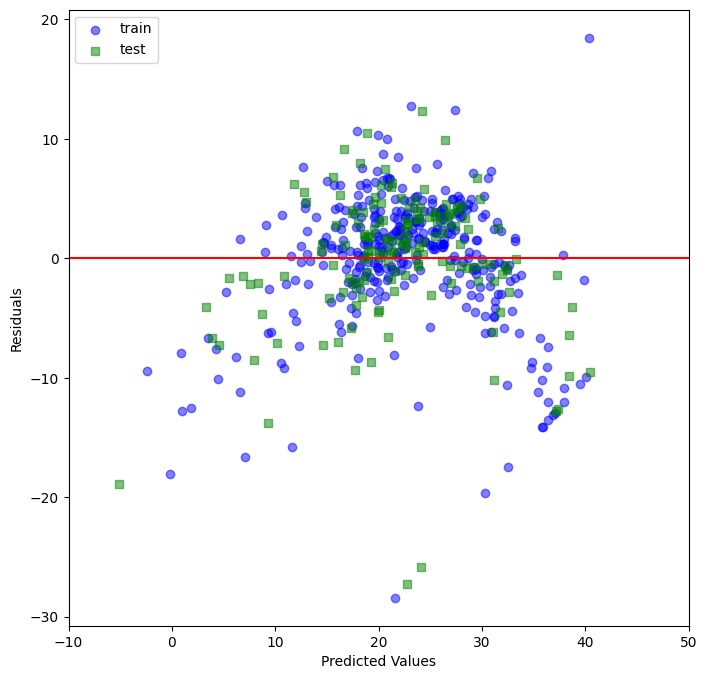

In [37]:
# 残差プロットを出力
res_plot(y_train, lr.predict(x_train), y_test, lr.predict(x_test))